## Get FGPU IPython Package

In [1]:
!sudo -H pip install --upgrade 'git+https://github.com/malkadi/FGPU_IPython'

  Cloning https://github.com/malkadi/FGPU_IPython to /tmp/pip-mlmq4_ae-build
  Found existing installation: FGPU 0.1
    Uninstalling FGPU-0.1:
      Successfully uninstalled FGPU-0.1
  Running setup.py install for FGPU ... - \ | / - \ | / - \ done


## Kernel Code
This kernel applies a 3x3 median filter on an RGB image.
The RGB values of each pixel are stored in a seperate 32bit word.

In [2]:
%%writefile median.cl

#include "FGPUlib.c"

#define sort3(a, b, c){                 \
  unsigned pos_a, pos_b, pos_c;         \
  unsigned tmp_a, tmp_b;                \
  unsigned a_bigger_b, a_bigger_c;      \
  unsigned b_bigger_c;                  \
  a_bigger_b = (a) > (b);               \
  a_bigger_c = (a) > (c);               \
  b_bigger_c = (b) > (c);               \
  pos_a = a_bigger_c + a_bigger_b;      \
  pos_b = !a_bigger_b + b_bigger_c;     \
  pos_c = !a_bigger_c + !b_bigger_c;    \
  tmp_a = (a);                          \
  tmp_b = (b);                          \
  (a) = pos_b == 0 ? (b):(a);           \
  (a) = pos_c == 0 ? (c):(a);           \
  (b) = pos_a == 1 ? tmp_a:(b);         \
  (b) = pos_c == 1 ? (c):(b);           \
  (c) = pos_a == 2 ? tmp_a:(c);         \
  (c) = pos_b == 2 ? tmp_b:(c);         \
}

__kernel void median(__global unsigned *in, __global unsigned *out){
  unsigned x = get_global_id(1);
  unsigned y = get_global_id(0);
  unsigned rowLen = get_global_size(0);
  unsigned p00, p01, p02;
  unsigned p10, p11, p12;
  unsigned p20, p21, p22;
  unsigned res = 0;
  
  // return on boarder pixels
  bool border =  x < 1 | y < 1 | (x>rowLen-2) | (y>rowLen-2);
  if(border) 
    return;

  // read pixels
  p00 = in[(x-1)*rowLen+y-1];
  p10 = in[x*rowLen+y-1];
  p20 = in[(x+1)*rowLen+y-1];
  p01 = in[(x-1)*rowLen+y];
  p11 = in[x*rowLen+y];
  p21 = in[(x+1)*rowLen+y];
  p02 = in[(x-1)*rowLen+y+1];
  p12 = in[x*rowLen+y+1];
  p22 = in[(x+1)*rowLen+y+1];

  // calculate r values
  unsigned p00r, p01r, p02r;
  unsigned p10r, p11r, p12r;
  unsigned p20r, p21r, p22r;

  p00r = p00 & 255;
  p01r = p01 & 255;
  p02r = p02 & 255;
  p10r = p10 & 255;
  p11r = p11 & 255;
  p12r = p12 & 255;
  p20r = p20 & 255;
  p21r = p21 & 255;
  p22r = p22 & 255;
  // sort rows
  sort3(p00r, p01r, p02r);
  sort3(p10r, p11r, p12r);
  sort3(p20r, p21r, p22r);
  //sort columns
  sort3(p00r, p10r, p20r);
  sort3(p01r, p11r, p21r);
  sort3(p02r, p12r, p22r);
  //sort diagonal
  sort3(p00r, p11r, p22r);

  res = p11r;

  // calculate g values
  unsigned p00g, p01g, p02g;
  unsigned p10g, p11g, p12g;
  unsigned p20g, p21g, p22g;
  
  p00g = (p00>>8) & 255;
  p01g = (p01>>8) & 255;
  p02g = (p02>>8) & 255;
  p10g = (p10>>8) & 255;
  p11g = (p11>>8) & 255;
  p12g = (p12>>8) & 255;
  p20g = (p20>>8) & 255;
  p21g = (p21>>8) & 255;
  p22g = (p22>>8) & 255;
  // sort rows
  sort3(p00g, p01g, p02g);
  sort3(p10g, p11g, p12g);
  sort3(p20g, p21g, p22g);
  //sort columns
  sort3(p00g, p10g, p20g);
  sort3(p01g, p11g, p21g);
  sort3(p02g, p12g, p22g);
  //sort diagonal
  sort3(p00g, p11g, p22g);

  res |= p11g<<8;


  // calculate b values
  unsigned p00b, p01b, p02b;
  unsigned p10b, p11b, p12b;
  unsigned p20b, p21b, p22b;
  
  p00b = (p00>>16) & 255;
  p01b = (p01>>16) & 255;
  p02b = (p02>>16) & 255;
  p10b = (p10>>16) & 255;
  p11b = (p11>>16) & 255;
  p12b = (p12>>16) & 255;
  p20b = (p20>>16) & 255;
  p21b = (p21>>16) & 255;
  p22b = (p22>>16) & 255;
  // sort rows
  sort3(p00b, p01b, p02b);
  sort3(p10b, p11b, p12b);
  sort3(p20b, p21b, p22b);
  //sort columns
  sort3(p00b, p10b, p20b);
  sort3(p01b, p11b, p21b);
  sort3(p02b, p12b, p22b);
  //sort diagonal
  sort3(p00b, p11b, p22b);

  res |= p11b << 16;
  
  res |= 0xFF000000; //to be compliant to RGBA format

  out[x*rowLen+y] = res;
}

Overwriting median.cl


## Create Objects

In [3]:
from FGPU import FGPU
from FGPU import xlnk

fgpu= FGPU()
mem=xlnk.xlnk()
mem.cma_stats()

{'Buffer Count': 0, 'CMA Memory Available': 133939200, 'CMA Memory Usage': 0}

## Program Hardware

In [4]:
fgpu.set_bitFile("V2_8CUs_SubInteger_2K_LMEM_240MHz.bit")
fgpu.download_bitstream()

## Compile Kernel

In [5]:
fgpu.set_kernel_file("median.cl")
fgpu.compile_kernel(False)

Compiling /home/muhammed/FGPU_IPython/notebooks/median.cl
Compiling succeeded!




## Read Input Image & Allocate Memory

In [6]:
import cv2
import scipy.misc as smp
import numpy as np
img_rgb = smp.face()
m = (0,0,0) #mean value of added noise on the RGB channels
s = (30,30,30) #standard variance of added noise of the RGB channels
noisy_rgb = np.zeros(img_rgb.shape, img_rgb.dtype)
cv2.randn(noisy_rgb,m,s);
noisy_rgb += img_rgb
img = cv2.cvtColor(noisy_rgb, cv2.COLOR_RGB2RGBA)

In [7]:
from cffi import FFI
ffi = FFI()
nRows = img.shape[0]
nCols = img.shape[1]
length = nRows*nCols # length of input and output array
img_ptr = mem.cma_alloc(length, data_type = "unsigned")
res_fgpu = mem.cma_alloc(length, data_type = "unsigned")
if type(img) == np.ndarray:
    ffi.memmove(img_ptr, img, img.size*img.dtype.itemsize)
else:
    AssertionError()
mem.cma_stats()

{'Buffer Count': 2,
 'CMA Memory Available': 127647744,
 'CMA Memory Usage': 6291456}

## Configure Kernel

In [8]:
# bind allocated memory to kenel parameters
fgpu.set_paramerter(0, img_ptr, mem)
fgpu.set_paramerter(1, res_fgpu, mem)
# setup index space
fgpu.set_num_dimensions(2)
fgpu.set_size(size=nCols, dim=0)
fgpu.set_size(size=nRows, dim=1)
fgpu.set_work_group_size(wg_size=8, dim=0)
fgpu.set_work_group_size(wg_size=8, dim=1)
fgpu.set_offset(value=0, dim=0)
fgpu.set_offset(value=0, dim=1)
fgpu.prepare_kernel_descriptor()

## Execute On FGPU

In [9]:
fgpu.download_kernel()
execTime = fgpu.execute_kernel()
print ("Execution time =", int(execTime*1000), "ms")


Execution time = 43 ms


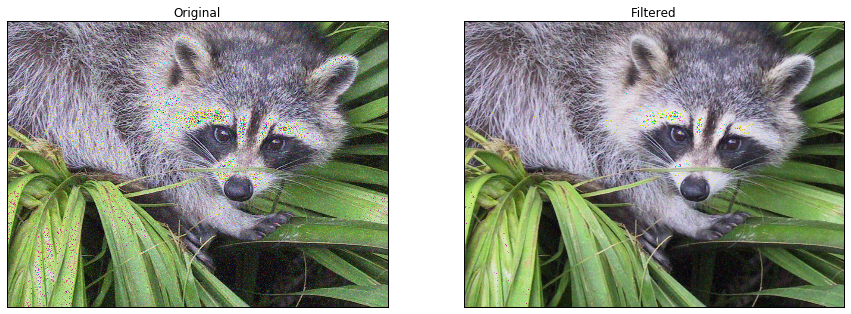

In [12]:
from matplotlib import pyplot as plt
import numpy as np
buffer_size = img.size*img.dtype.itemsize
c_buffer = ffi.buffer(res_fgpu,buffer_size)
res_fgpu_ndarray = np.frombuffer(c_buffer, dtype=img.dtype)
res_fgpu_reshaped = res_fgpu_ndarray.reshape(img.shape)

plt.figure(1, figsize=(15, 10))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(res_fgpu_reshaped),plt.title('Filtered')
plt.xticks([]), plt.yticks([])
plt.show()

## Compute without FGPU

Execution time = 364 ms


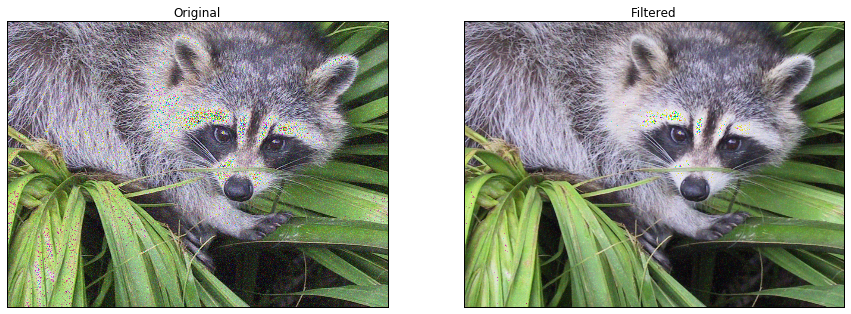

In [11]:
from matplotlib import pyplot as plt
import time
start = time.time()
cv2_median = cv2.medianBlur(noisy_rgb,3)
end = time.time()
print ("Execution time =", int((end-start)*1000), "ms")
plt.figure(1, figsize=(15, 10))
plt.subplot(121),plt.imshow(noisy_rgb),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cv2_median),plt.title('Filtered')
plt.xticks([]), plt.yticks([])
plt.show()